# Imports

In [154]:
!pip install scikit-posthocs

In [155]:
# Files & Time
import os
import time

# Linear Algebra
import numpy as np

# Multi thread & processing
import multiprocessing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning general and Data Modelling
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Image processing
import cv2

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, rankdata

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Dataset

In [198]:
def get_list_of_files(directory):
  allFiles = []
  for root, dirs, files in os.walk(directory):
    for file in files:
        fullPath = os.path.join(root, file)
        allFiles.append(fullPath)
  return allFiles

def process_image(image_path, use_background_removal=False):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150), interpolation=cv2.INTER_AREA)
    if use_background_removal:
        img = remove_background_binary(img)
    label = os.path.basename(os.path.dirname(image_path))
    return img, label, image_path

def prepare_data(dataset, num_workers=2, use_background_removal=False):
    with multiprocessing.Pool(num_workers) as pool:
        results = pool.starmap(
            process_image,
            [(image_path, use_background_removal) for image_path in dataset]
        )

    data = [res[0] for res in results]
    labels = [res[1] for res in results]
    paths = [res[2] for res in results]

    return np.array(data), np.array(labels), paths


# Image Processing

## Remove Background

In [190]:
def remove_background_binary(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    saturation = hsv_image[:, :, 1]
    _, binary_mask = cv2.threshold(saturation, 85, 255, cv2.THRESH_BINARY)
    masked_image = cv2.bitwise_and(image, image, mask=binary_mask)
    return masked_image

## Find Optimal Cluster

In [191]:
def find_optimal_k(gaps, s_k, max_k):
    for k in range(1, max_k):
        if gaps[k - 1] >= gaps[k] - s_k[k]:
            return k
    return max_k

def gap_statistic_for_k(pixel_values, k, n_refs=10, random_state=42):
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    kmeans.fit(pixel_values)

    disp = np.sum(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    ref_disps = np.zeros(n_refs)
    for i in range(n_refs):
        random_reference = np.random.uniform(
            low=pixel_values.min(axis=0),
            high=pixel_values.max(axis=0),
            size=pixel_values.shape
        )
        kmeans.fit(random_reference)
        ref_disps[i] = np.sum(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    log_ref_disp = np.log(ref_disps + 1e-10)
    gap = np.mean(log_ref_disp) - np.log(disp + 1e-10)
    s_k = np.sqrt(np.sum((log_ref_disp - np.mean(log_ref_disp))**2) / n_refs)
    return gap, s_k

def calculate_gap_statistic(image, max_k=10, n_refs=10, random_state=42):
    pixel_values = np.ascontiguousarray(image.reshape((-1, 3)))
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)

    for k in range(1, max_k + 1):
        gap, sk = gap_statistic_for_k(pixel_values, k, n_refs=n_refs, random_state=random_state)
        gaps[k - 1] = gap
        s_k[k - 1] = sk

    return gaps, s_k

# Image Segmentation

In [192]:
def k_mean_segmentation(disease, attempts=10, K=2):
    disease = remove_background_binary(disease)
    leaf_image = disease.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(leaf_image, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(disease.shape)
    return segmented_image, labels, centers

def segment_image(image, K=2):
    return k_mean_segmentation(image, K=K)

def process_image(args):
    image, max_k = args
    # gaps, s_k = calculate_gap_statistic(image, max_k=max_k)
    # optimal_k = find_optimal_k(gaps, s_k, max_k)
    return k_mean_segmentation(image, K=8)

def parallel_segmentation(images, max_k=10, num_workers=2):
    with multiprocessing.get_context("fork").Pool(processes=num_workers) as pool:
        args = [(image, max_k) for image in images]
        results = pool.map(process_image, args)
    return results

# Feature Extraction

In [193]:
def extract_hsv_features(images, labels=None, centers=None, use_segmentation=True):
    """
    Extract mean HSV features from images (with or without segmentation).

    Parameters:
    - images: List of images (either segmented or original images).
    - labels: List of label arrays corresponding to each image (needed if use_segmentation=True).
    - centers: List of cluster center arrays corresponding to each image (needed if use_segmentation=True).
    - use_segmentation: Boolean flag to determine whether to use K-means segmentation or not.

    Returns:
    - features: Flattened HSV features for all images.
    """
    features = []

    for i, image in enumerate(images):
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        if use_segmentation:
            # Check that segmentation data is available
            if labels is None or centers is None:
                raise ValueError("When use_segmentation is True, labels and centers must be provided.")

            label_array = labels[i]
            center_array = centers[i]

            image_features = []
            num_clusters = len(center_array)

            for cluster_id in range(num_clusters):
                cluster_mask = (label_array.reshape(image.shape[:2]) == cluster_id)

                cluster_pixels = hsv_image[cluster_mask]

                if cluster_pixels.size > 0:
                    mean_hsv = cluster_pixels.mean(axis=0)
                else:
                    mean_hsv = [0, 0, 0]

                image_features.extend(mean_hsv)

        else:
            # Extract mean HSV of the entire image
            mean_hsv = hsv_image.mean(axis=(0, 1))
            image_features = mean_hsv

        features.append(image_features)

    return np.array(features)

In [194]:
def extract_histogram_features(images, labels_list=None, centers_list=None, hist_bins=16, use_segmentation=True):
    """
    Extract HSV histogram features for a list of images (with or without segmentation).

    Args:
    - images (list of np.array): List of images (either segmented or original).
    - labels_list (list of np.array, optional): List of label arrays corresponding to segmented images (needed if use_segmentation=True).
    - centers_list (list of np.array, optional): List of cluster centers (needed if use_segmentation=True).
    - hist_bins (int): Number of bins for the histogram (default is 16).
    - use_segmentation (bool): Flag to determine whether to use segmentation or not (default is True).

    Returns:
    - all_features (list of np.array): List of flattened histogram feature vectors for all images.
    """
    all_features = []

    for i, image in enumerate(images):
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        if use_segmentation:
            if labels_list is None or centers_list is None:
                raise ValueError("When use_segmentation is True, labels_list and centers_list must be provided.")

            labels = labels_list[i]
            centers = centers_list[i]

            for cluster_id in range(len(centers)):
                cluster_mask = (labels.reshape(image.shape[:2]) == cluster_id).astype(np.uint8)

                h_hist = cv2.calcHist([hsv_image], [0], cluster_mask, [hist_bins], [0, 180])
                s_hist = cv2.calcHist([hsv_image], [1], cluster_mask, [hist_bins], [0, 256])
                v_hist = cv2.calcHist([hsv_image], [2], cluster_mask, [hist_bins], [0, 256])

                h_hist = cv2.normalize(h_hist, h_hist).flatten()
                s_hist = cv2.normalize(s_hist, s_hist).flatten()
                v_hist = cv2.normalize(v_hist, v_hist).flatten()

                features.extend(h_hist)
                features.extend(s_hist)
                features.extend(v_hist)

        else:
            h_hist = cv2.calcHist([hsv_image], [0], None, [hist_bins], [0, 180])
            s_hist = cv2.calcHist([hsv_image], [1], None, [hist_bins], [0, 256])
            v_hist = cv2.calcHist([hsv_image], [2], None, [hist_bins], [0, 256])

            h_hist = cv2.normalize(h_hist, h_hist).flatten()
            s_hist = cv2.normalize(s_hist, s_hist).flatten()
            v_hist = cv2.normalize(v_hist, v_hist).flatten()

            features.extend(h_hist)
            features.extend(s_hist)
            features.extend(v_hist)

        all_features.append(np.array(features))

    return all_features

# Normalization

In [195]:
def normalize_features(features, method="standard"):
    """
    Normalize or standardize features.

    Parameters:
    - features: Feature matrix (NumPy array)
    - method: Normalization method, "standard" (default) or "minmax".

    Returns:
    - Normalized feature matrix.
    """
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    return scaler.fit_transform(features)

---

# Execution

---

In [196]:
train_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Train")
test_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Test")

In [199]:
# X_train, y_train, train_paths = prepare_data(train_ds, num_workers=2, use_background_removal=False)
# X_test, y_test, test_paths = prepare_data(test_ds, num_workers=2, use_background_removal=False)

X_train, y_train, train_paths = prepare_data(train_ds, num_workers=2, use_background_removal=True)
X_test, y_test, test_paths = prepare_data(test_ds, num_workers=2, use_background_removal=True)

## Without Segmentation

In [200]:
# X_train_hsv = extract_hsv_features(X_train, use_segmentation=False)
# X_test_hsv = extract_hsv_features(X_test, use_segmentation=False)

X_train_hsv = extract_histogram_features(X_train, use_segmentation=False)
X_test_hsv = extract_histogram_features(X_test, use_segmentation=False)

In [201]:
if X_train.ndim > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

X_train_normalized = normalize_features(X_train, method="minmax")
X_test_normalized = normalize_features(X_test, method="minmax")

## K Mean Segmentation

In [14]:
train_segmented_images = parallel_segmentation(X_train, max_k=8, num_workers=2)


In [15]:
test_segmented_images = parallel_segmentation(X_test, max_k=8, num_workers=2)

In [16]:
train_segmented = [segmented_image for segmented_image, _, _ in train_segmented_images]
train_labels = [label for _, label, _ in train_segmented_images]
train_centers = [center for _, _, center in train_segmented_images]

In [17]:
test_segmented = [segmented_image for segmented_image, _, _ in test_segmented_images]
test_labels = [label for _, label, _ in test_segmented_images]
test_centers = [center for _, _, center in test_segmented_images]

In [73]:
X_train = extract_histogram_features(train_segmented, train_labels, train_centers)
X_test = extract_histogram_features(test_segmented, test_labels, test_centers)

# X_train = extract_hsv_features(train_segmented, train_labels, train_centers)
# X_test = extract_hsv_features(test_segmented, test_labels, test_centers)

In [74]:
X_train_normalized = normalize_features(X_train, method="minmax")
X_test_normalized = normalize_features(X_test, method="minmax")

In [75]:
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

---
## Evaluation

In [202]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=1.0),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=3),
}

In [203]:
for name, model in models.items():
    model.fit(X_train_normalized, y_train)

### Confusion Matrix

#### Heatmap

In [204]:
def evaluate_cm_heatmap(models, X_test, y_test, rows=2, cols=3):
    """
    Plot confusion matrices for multiple models in a grid layout.

    Parameters:
    - models: Dictionary of model names and trained models.
    - X_test: Test features.
    - y_test: Test labels.
    - rows: Number of rows in the grid.
    - cols: Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easier indexing

    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[idx]
        )
        axes[idx].set_title(f"Confusion Matrix: {name}")
        axes[idx].set_xlabel("Predicted Label")
        axes[idx].set_ylabel("True Label")

    # Hide any unused subplots
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

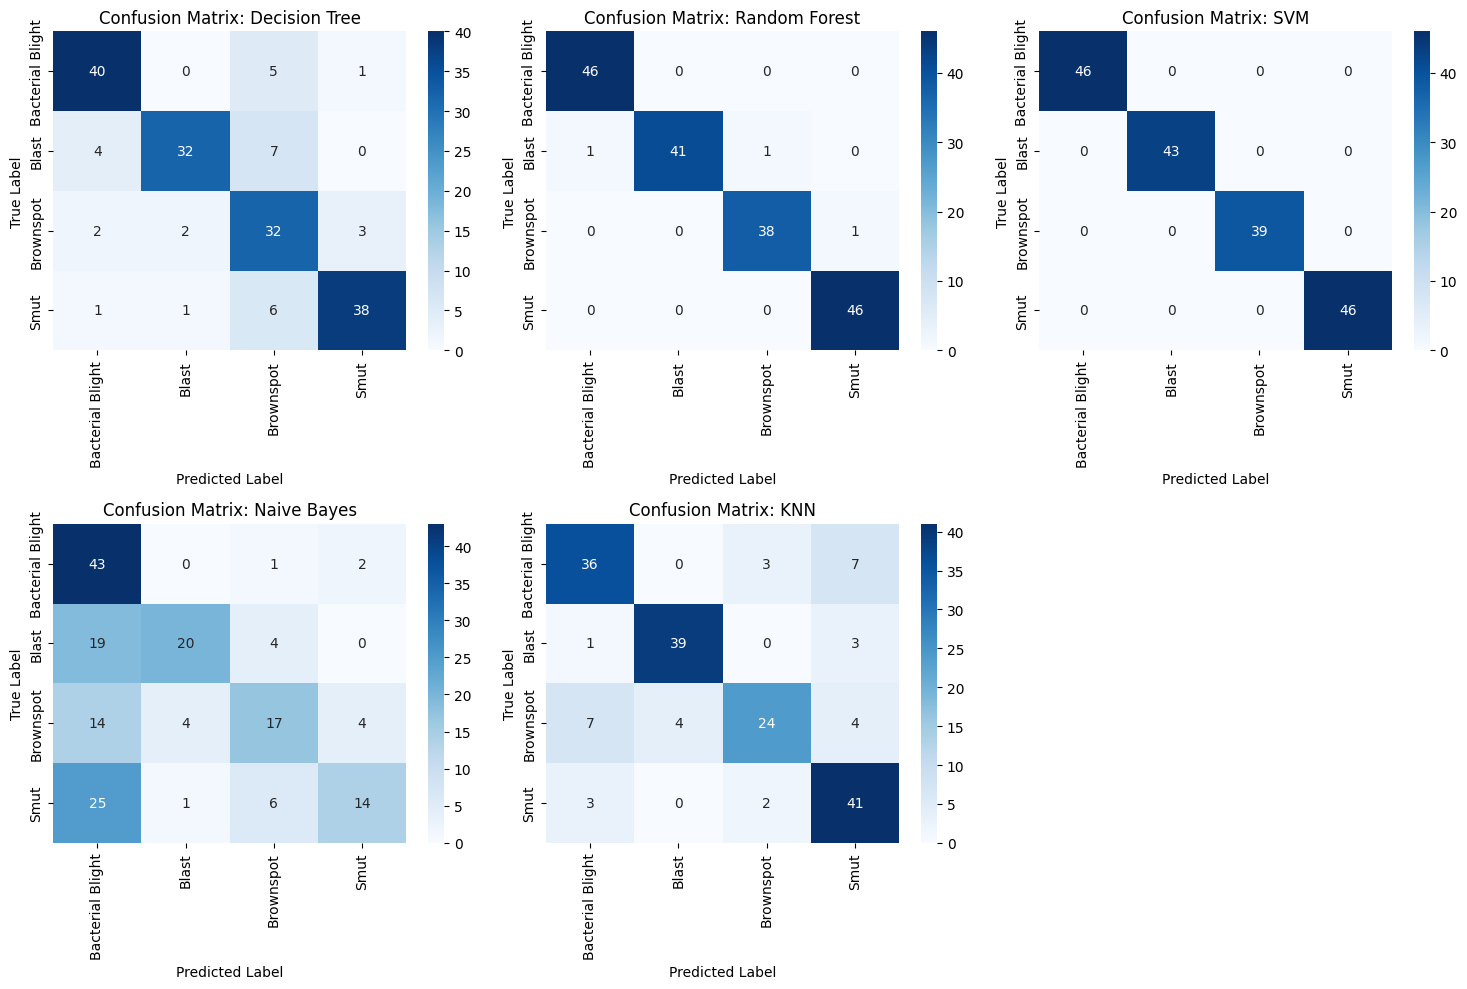

In [205]:
evaluate_cm_heatmap(models, X_test_normalized, y_test)

#### Metric Visualization

In [206]:
def calculate_metrics(models, X_test, y_test):
    """
    Calculate and visualize accuracy, precision, recall, and F1-score for all models.

    Parameters:
    - models: Dictionary of model names and trained models.
    - X_test: Test features.
    - y_test: Test labels.
    """
    from matplotlib import pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

    # Calculate metrics for each model
    for name, model in models.items():
        y_pred = model.predict(X_test)
        metrics["Model"].append(name)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred, average="weighted"))
        metrics["Recall"].append(recall_score(y_test, y_pred, average="weighted"))
        metrics["F1-Score"].append(f1_score(y_test, y_pred, average="weighted"))

    # Create DataFrame
    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index("Model", inplace=True)

    # Plot metrics
    ax = metrics_df.plot(kind="bar", figsize=(10, 6), title="Model Metrics Comparison", colormap="viridis")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid(axis="y")

    # Add numeric values above the bars
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=6
        )

    plt.show()

    return metrics_df


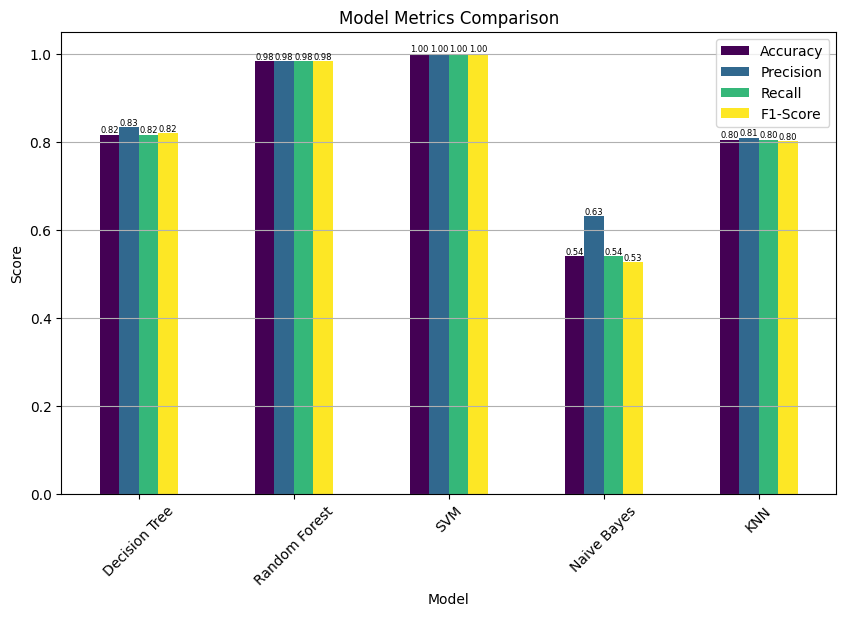

In [207]:
metrics_df = calculate_metrics(models, X_test_normalized, y_test)

#### Time Metrics

In [208]:
def calculate_time_metrics(models, X_train, y_train, X_test):
    """
    Measure and report training and prediction times for all models.

    Parameters:
    - models: Dictionary of model names and instantiated models.
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Test features.

    Returns:
    - time_metrics: DataFrame with training and prediction times.
    """
    times = {"Model": [], "Training Time (s)": [], "Prediction Time (s)": []}

    for name, model in models.items():
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()

        start_predict = time.time()
        model.predict(X_test)
        end_predict = time.time()

        times["Model"].append(name)
        times["Training Time (s)"].append(end_train - start_train)
        times["Prediction Time (s)"].append(end_predict - start_predict)

    time_metrics = pd.DataFrame(times)
    time_metrics.set_index("Model", inplace=True)
    time_metrics.plot(kind="bar", figsize=(10, 6), title="Training and Prediction Time Comparison", colormap="coolwarm")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

    return time_metrics

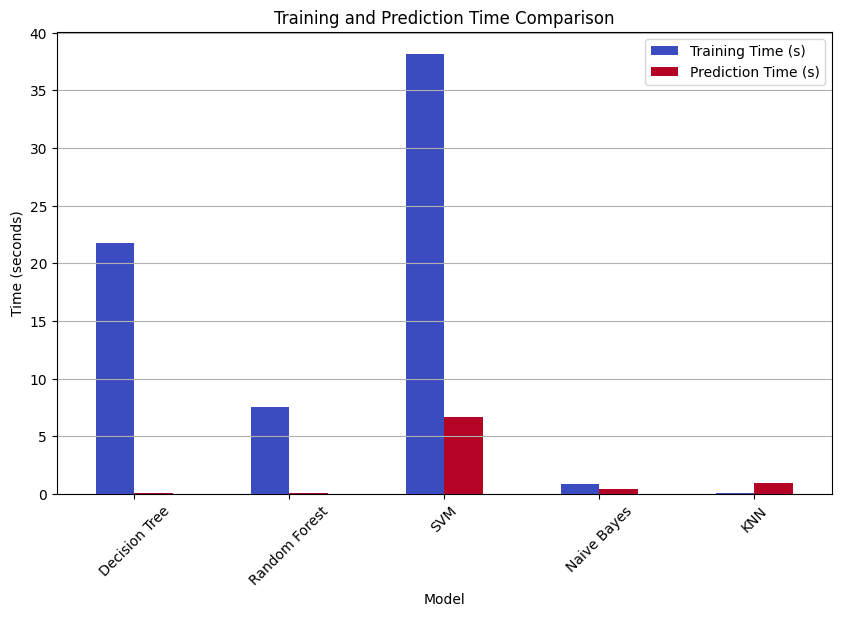

In [209]:
time_metrics_df = calculate_time_metrics(models,X_train_normalized, y_train, X_test_normalized)

### Learning Curves

In [210]:
def fix_evaluate_learning_curves(models, X, y, cv=5, scoring="accuracy"):
    """
    Evaluate learning curves for multiple models, with error handling for single-class folds.

    Parameters:
    - models: Dictionary of model names and instantiated models.
    - X: Features.
    - y: Labels.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.
    """
    plt.figure(figsize=(15, 8))

    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():
        try:
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y, cv=stratified_cv, scoring=scoring, n_jobs=-1, error_score='raise'
            )

            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)
            test_std = np.std(test_scores, axis=1)

            plt.plot(train_sizes, test_mean, label=f"{name} (CV Score)", marker="o")
            plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

        except ValueError as e:
            if "The number of classes has to be greater than one" in str(e):
                print(f"Warning: {name} encountered a fold with only one class, skipping this model.")
                continue  # Skip this model and move to the next one

    plt.title("Learning Curves for Multiple Models")
    plt.xlabel("Training Size")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

In [222]:
def evaluate_learning_curves(models, X, y, cv=10, scoring="accuracy"):
    """
    Evaluate learning curves for multiple models.

    Parameters:
    - models: Dictionary of model names and instantiated models.
    - X: Features.
    - y: Labels.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.
    """
    plt.figure(figsize=(15, 8))

    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=stratified_cv, scoring=scoring, n_jobs=-1, error_score='raise'
        )
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, test_mean, label=f"{name} (CV Score)", marker="o")
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.title("Learning Curves for Multiple Models")
    plt.xlabel("Training Size")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

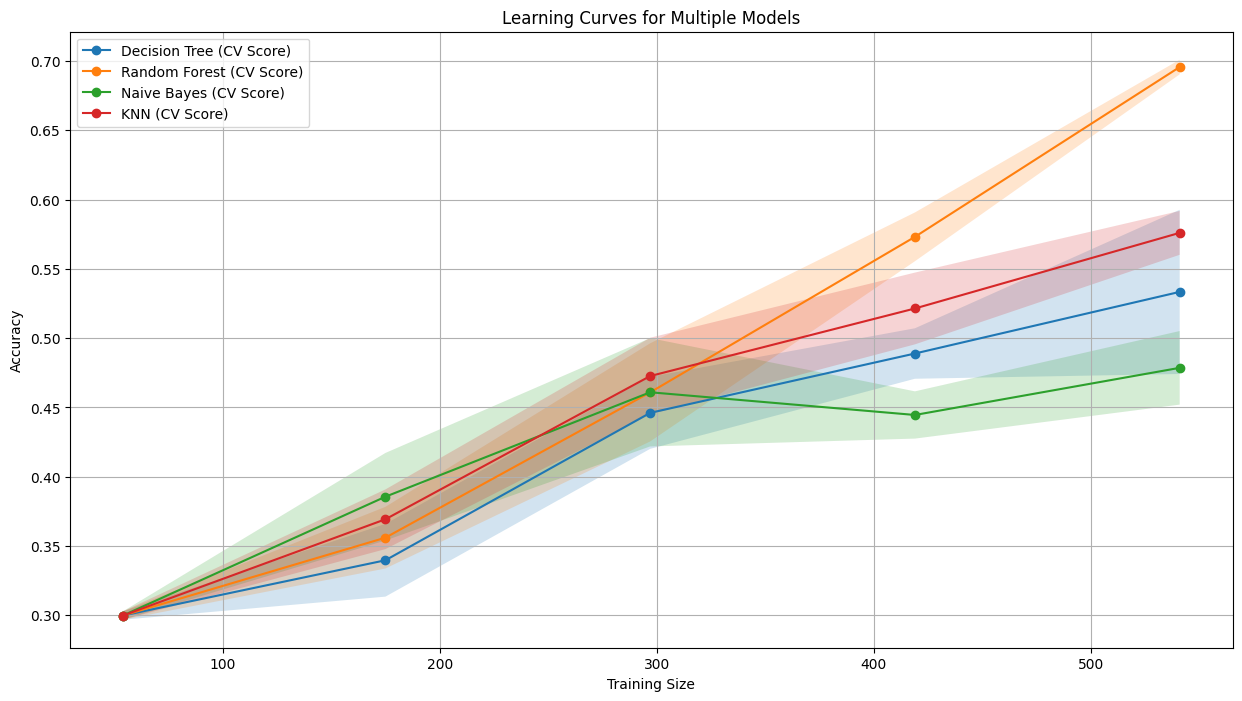

In [223]:
fix_evaluate_learning_curves(models, X_train_normalized, y_train)

In [213]:
from collections import Counter
print(Counter(y_train))

Counter({'Bacterial Blight': 203, 'Smut': 188, 'Brownspot': 147, 'Blast': 139})


### Friedman & PostHoc

In [214]:
def get_cv_results(models, X, y, cv=5, scoring="accuracy"):
    """
    Compute cross-validation results for multiple models.

    Parameters:
    - models: Dictionary of model names and instantiated models.
    - X: Features.
    - y: Labels.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.

    Returns:
    - results: Dictionary with model names as keys and CV scores as values.
    """
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        results[name] = scores
        print(f"{name}: Mean CV Score = {scores.mean():.4f} ± {scores.std():.4f}")
    return results

In [215]:
def perform_friedman_test(results):
    """
    Perform the Friedman test on multiple model results.

    Parameters:
    - results: Dictionary where keys are model names and values are lists of accuracy scores (e.g., from cross-validation).

    Returns:
    - Test statistic and p-value.
    """
    scores = list(results.values())
    stat, p = friedmanchisquare(*scores)
    print(f"Friedman Test Statistic: {stat:.2f}, p-value: {p:.4f}")
    return stat, p

In [216]:
def perform_post_hoc_test(results):
    """
    Perform the Nemenyi post-hoc test after the Friedman test.

    Parameters:
    - results: Dictionary where keys are model names and values are lists of accuracy scores (e.g., from cross-validation).

    Returns:
    - Pairwise comparison matrix as a NumPy array.
    """
    # Convert the dictionary values to a 2D array
    scores = np.array(list(results.values())).T  # Transpose for pairwise tests

    # Perform the Nemenyi test
    nemenyi = sp.posthoc_nemenyi_friedman(scores)
    print("Post-Hoc Test (Nemenyi):\n", nemenyi)

    return nemenyi

In [217]:
cv_results = get_cv_results(models, X_train_normalized, y_train)

Decision Tree: Mean CV Score = 0.5081 ± 0.0425
Random Forest: Mean CV Score = 0.6692 ± 0.0377
SVM: Mean CV Score = 0.6012 ± 0.0251
Naive Bayes: Mean CV Score = 0.4655 ± 0.0592
KNN: Mean CV Score = 0.5480 ± 0.0402


In [218]:
perform_friedman_test(cv_results)

Friedman Test Statistic: 17.90, p-value: 0.0013


(17.8989898989899, 0.0012914713121915768)

In [219]:
p_values = perform_post_hoc_test(cv_results)

Post-Hoc Test (Nemenyi):
           0         1         2         3         4
0  1.000000  0.006069  0.179597  0.999977  0.562449
1  0.006069  1.000000  0.751424  0.004246  0.317223
2  0.179597  0.751424  1.000000  0.144775  0.956544
3  0.999977  0.004246  0.144775  1.000000  0.497325
4  0.562449  0.317223  0.956544  0.497325  1.000000


In [220]:
p_values_filled = np.nan_to_num(p_values, nan=1.0)

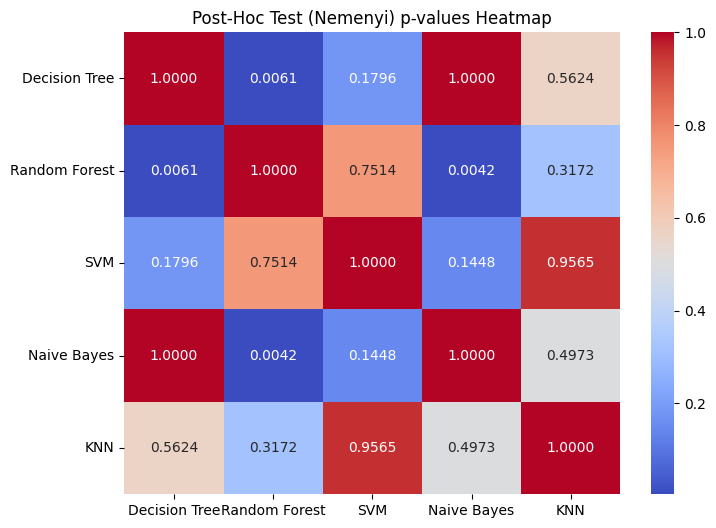

In [221]:
p_values_df = pd.DataFrame(p_values_filled, columns=models, index=models)

plt.figure(figsize=(8, 6))
sns.heatmap(p_values_df, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title("Post-Hoc Test (Nemenyi) p-values Heatmap")
plt.show()